# Creating a data driven network

This example shows how we create and add annotations to a data driven network.

In [2]:
%matplotlib inline
import sys
import os
import networkx as nx
from IPython.display import display, Image

In [3]:
# NBVAL_IGNORE_OUTPUT
from exp_data import exp_data
import magine.networks.utils as utils
from magine.networks.network_generator import build_network
from magine.networks.subgraphs import Subgraph
import magine.networks.exporters as exporters
import magine.networks.visualization as viz

2019-07-01 11:14:25.012 - magine - INFO - Logging started on MAGINE
2019-07-01 11:14:25.015 - magine - INFO - Log entry time offset from UTC: -7.00 hours


Creating list of seed species and background species for network

In [4]:
measured = exp_data.species.id_list
sig_measured = exp_data.species.sig.id_list
print(len(measured))
print(len(sig_measured))

54750
14136


Now we will create the network. We pass the seed and background list to the network as well as flags turning on all of the network databases. We also trim source/sink nodes (optional). This basically cleans up dangling nodes that are not in our seed or background lists.

In [5]:
save_name = 'bendamustine_network_w_attributes'

execute = False

if execute:
    network = build_network(
        seed_species=sig_measured,  # seed species
        all_measured_list=measured,  # all data measured
        use_biogrid=True,  # expand with biogrid
        use_hmdb=True,  # expand with hmdb
        use_reactome=True,  # expand with reactome
        use_signor=True,  # expand with signor
        trim_source_sink=True,  # remove all source and sink nodes not measured
        save_name='Networks/bendamustine_network'
    )
    # add data to networks
    network = utils.add_data_to_graph(network, exp_data)

    # write to GML for cytoscape or other program
    nx.write_gml(network, os.path.join('Networks', save_name+'.gml'))

    # write to gpickle for fast loading in python
    nx.write_gpickle(network, os.path.join('Networks', save_name+'.p'))
else:
    network = nx.read_gpickle(os.path.join('Networks', save_name+'.p'))

In [7]:
print(len(network.nodes))
print(len(network.edges))

21130
515061


21130 nodes and 515061 edges are too much to manually explore. Thus, we are going to use the `Subgraph` Class to being to query the network.

In [8]:
# initialize it
net_sub = Subgraph(network)

In [10]:
help(net_sub)

Help on Subgraph in module magine.networks.subgraphs object:

class Subgraph(builtins.object)
 |  Subgraph(network, exp_data=None, pool=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, network, exp_data=None, pool=None)
 |      Generates network subgraphs
 |      
 |      Parameters
 |      ----------
 |      network : networkx.DiGraph
 |      exp_data : magine.data.datatypes.ExperimentalData
 |  
 |  downstream_of_node(self, species_1, include_list=None, save_name=None, draw=False)
 |      Generate network of all downstream species of provides species
 |      
 |      
 |      Parameters
 |      ----------
 |      species_1 : str
 |          species name
 |      save_name : str
 |          name to save gml file
 |      draw : bool
 |          create figure of graph
 |      include_list : list_like
 |          list of species that must be in path in order to consider a path
 |      Returns
 |      -------
 |      nx.DiGraph
 |      
 |      
 |      Examples
 |      -------

## Exploring neighbors of nodes of interest

For demonstration purposes, we are starting with the protein CASP3. CASP3 is an effector caspsase that is required for apoptosis. It cleaves other proteins and starts the degradation [CASP3]( https://www.genecards.org/cgi-bin/carddisp.pl?gene=CASP3). We start our exploration at CASP3 as it is a marker for intrinsic apoptosis, which is what is generally regarded as bendamustines pathway for cell death.

First, we are going to look at all the neighbors of CASP3 that were signficantly changed in our experimental data.

In [23]:
casp3_neighbors = net_sub.neighbors(
    'CASP3', # node of interest
    upstream=True, # include upstream nodes
    downstream=False,  # include downstream nodes
    include_only=exp_data.species.sig.id_list # limit nodes to only significant changed species
)

In [24]:
# one of many ways to draw the network.
# draw_cyjs is ideal for Jupyter notebooks since it allows us to move nodes, apply various layouts
# Notice that if you click on an edge, it provides you with the interaction type.
# If you click on a node, it provides a link to genecards.
viz.draw_cyjs(casp3_neighbors)

Next we can continue to expand this network to explore nodes of interest.

This next function expands a single node and creates plots of the species that are connected to thht node.

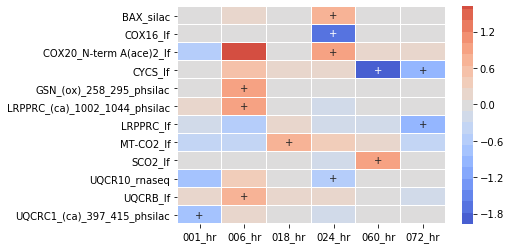

In [61]:
def show_neighbors(node, df, upstream=True, downstream=False, max_dist=1, 
                   include_only=None, figsize=None, show_network=False):
    
    neighbors = net_sub.expand_neighbors(
        network=None, 
        nodes=node,
        upstream=upstream, 
        downstream=downstream, 
        max_dist=max_dist,
        include_only=include_only
    )
    df_copy = df.subset(neighbors.nodes).copy()
    
    # remove nodes not connected to casp3
    neighbors = utils.delete_disconnected_network(neighbors)
    
    # moves a time point if no signficant changes
    df_copy.require_n_sig(n_sig=1, inplace=True, index='sample_id', columns='label',)
    
    # removes measured species if no signficant changes
    df_copy.require_n_sig(n_sig=1, index='label', inplace=True)
    if show_network:
        # export image
        s_name =  'node_{}.png'.format(node)
        exporters.export_to_dot(neighbors, s_name, image_format='png', engine='circo')

        # display image
        display(Image(s_name, width=400))
    
    # create heatmap of the neighnor nodes
    fig = df_copy.heatmap(
        rank_index=True, 
        index='label',
        linewidths=0.01,
        figsize=figsize
    );
    
    
show_neighbors('CYCS', 
               exp_data.species,
               upstream=True, 
               downstream=False, 
               max_dist=1,
               include_only=exp_data.species.sig.id_list
)

In [62]:
expand = net_sub.expand_neighbors(casp3_neighbors, 
                                  nodes='CYCS',
                                  upstream=True, 
                                  include_only=exp_data.species.sig.id_list)

In [63]:
viz.draw_cyjs(expand)

In [64]:
expand = net_sub.expand_neighbors(expand, nodes='BAX', upstream=True, include_only=exp_data.species.sig.id_list)
viz.draw_cyjs(expand)

In [65]:
expand = net_sub.expand_neighbors(expand, nodes='BID', upstream=True, include_only=exp_data.species.sig.id_list)
viz.draw_cyjs(expand)

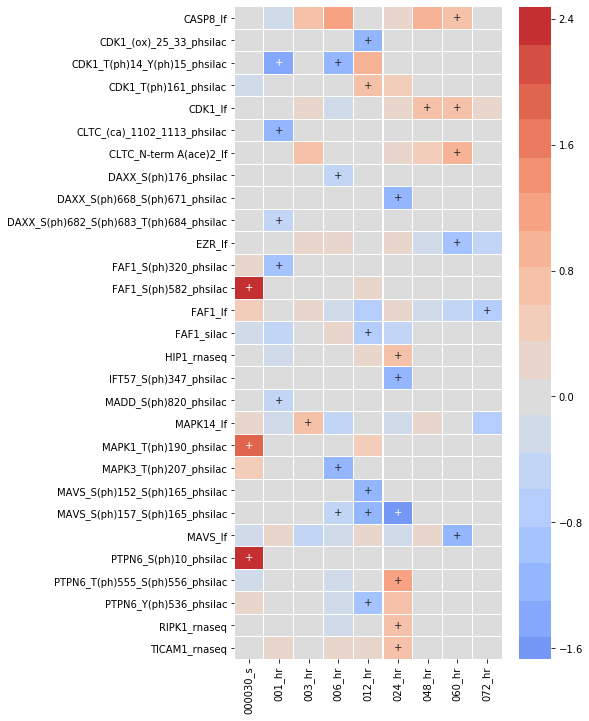

In [67]:
show_neighbors('CASP8', 
               exp_data.species,
               upstream=True, 
               downstream=False, 
               max_dist=1,
               include_only=exp_data.species.sig.id_list,
               figsize=(6, 12)
)

In [68]:
expand = net_sub.expand_neighbors(expand, nodes='CASP8', upstream=True, include_only=exp_data.species.sig.id_list)
viz.draw_cyjs(expand)

In [ ]:
show_neighbors(['FAF1', 'MADD', 'DAXX'], 
               exp_data.species,
               upstream=True, 
               downstream=False, 
               max_dist=1,
               include_only=exp_data.species.require_n_sig(n_sig=1).id_list,
               figsize=(8, 6)
)

In [79]:
expand = net_sub.expand_neighbors(expand, 
                                  nodes=['FAF1', 'MADD', 'DAXX'], 
                                  upstream=True, 
                                  include_only=exp_data.species.sig.id_list)
# NBVAL_IGNORE_OUTPUT
viz.draw_cyjs(expand)

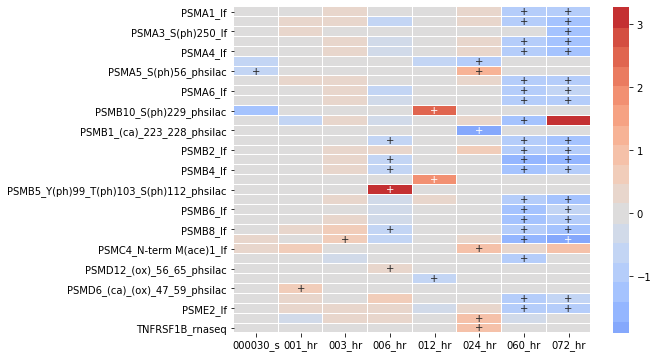

In [70]:
show_neighbors('TNFRSF1B', 
               exp_data.species,
               upstream=True, 
               downstream=False, 
               max_dist=1,
               include_only=exp_data.species.require_n_sig(n_sig=1).id_list,
               figsize=(8, 6)
)

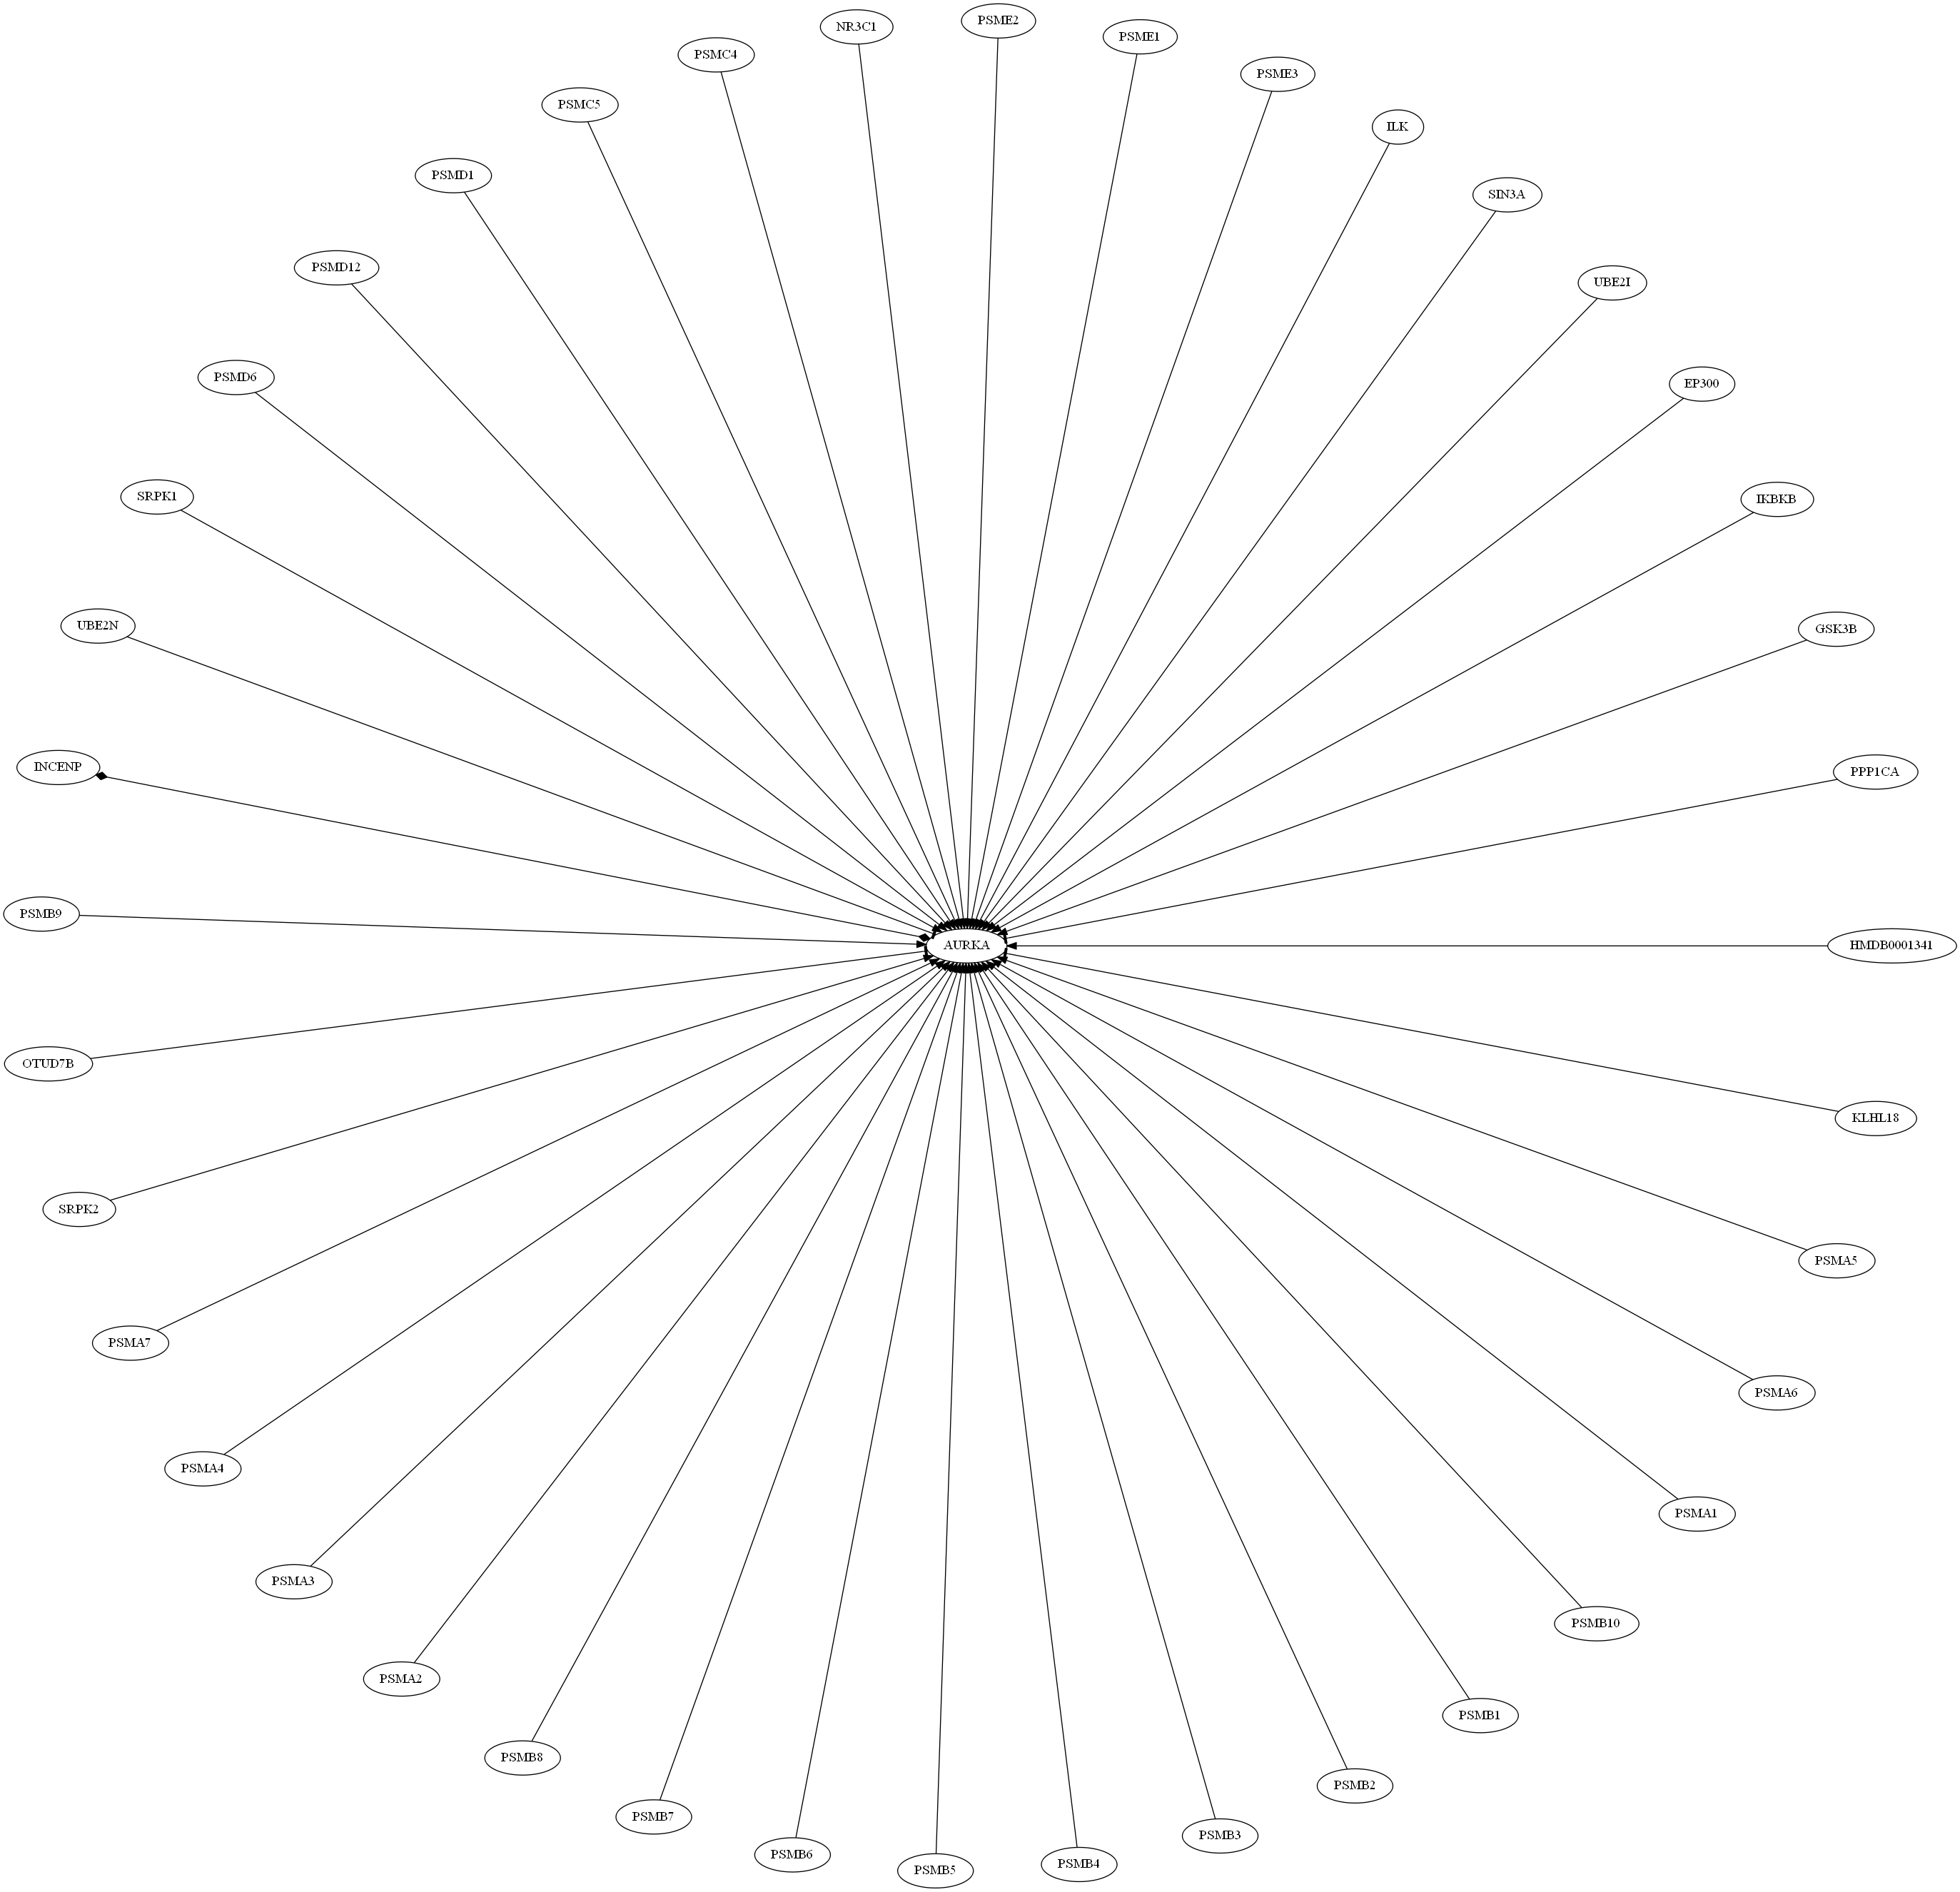

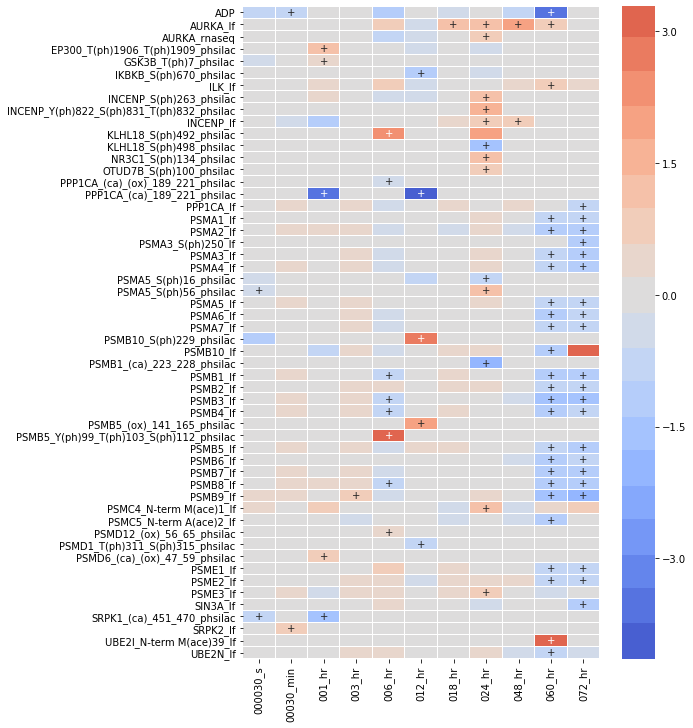

In [71]:
show_neighbors('AURKA', 
               exp_data.species,
               upstream=True, 
               downstream=False, 
               max_dist=1,
               include_only=exp_data.species.require_n_sig(n_sig=1).id_list,
               figsize=(8, 12),
               show_network=True
)

In [83]:
expand = net_sub.expand_neighbors(expand, nodes=['AURKA'], upstream=True, include_only=exp_data.species.require_n_sig(n_sig=2).id_list)
# NBVAL_IGNORE_OUTPUT
viz.draw_cyjs(expand)

This last network has gotten a little hard to explore. We can simplify it by just looking for a single path, in this case AURKA to CYCS

In [87]:
sub_g_2 = Subgraph(expand)
aurka_to_cycs = sub_g_2.paths_between_pair('AURKA', 'CYCS')

In [88]:
viz.draw_cyjs(aurka_to_cycs)